<a href="https://colab.research.google.com/github/rant95/wine/blob/master/Prediction_Wine_of_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction Wine of quality


---
Lova Rant.


---
Febr 2019


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

L'objectif est de déterminer la qualité d’un vin (de 0 = très mauvais à 10 = exceptionnel) à partir de mesures physico-chimiques.

Détails : *http://archive.ics.uci.edu/ml/datasets/Wine+Quality*

On part du principe que si deux vins différents ont la même composition, leurs qualités gustatives seront identiques. Dans la base de données il y a 6 400 vins rouges et blancs provenant du Portugal. Si un vin inconnu a une composition identique à l’un des 6400 vins répertoriés, on peut supposer qu’il obtiendra la même note.

Avec les algorithmes d'apprentissage utilisés en RCP209, je vais proposer une façon de construire une note pour une composition nouvelle. Je vais donc faire une prédiction et avec le savoir accumulé sur 6400 vins, je vais tenter de prédire ou estimer la note.

Voici le jeu de données qui contient 6497 vins et 13 variables dont 1 variables quantitative illustrative et 1 variables qualitative illustrative.

In [ ]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
import numpy as np
import imp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from scipy.stats import uniform
from scipy.stats import norm
import encodings


#1.Import the dataset

In [ ]:
# import the dataset

df_red = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Wine/winequality-red.csv', sep=';')

df_red.head(10)
df_red.describe()

df_white = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Wine/winequality-white.csv', sep=';')
df_white.info()
df_white.head(10)
df_white.describe()

df_white['color'] = "W"

df_red['color'] = "R"
df = pd.concat([df_red, df_white])
df.head(10)
df["color"].value_counts() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


W    4898
R    1599
Name: color, dtype: int64

In [ ]:

vins=df

print(vins.describe())

X = vins.drop(['quality','color'],axis=1)
Y = vins['quality']


vins["color"].value_counts()

print(len(vins[vins.color == 'W']), "vins Blanc")
print(len(vins[vins.color == 'R']), "vins Rouge")

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

On dispose de plusieurs milliers de notes données par des experts à des milliers de vins dont on connaît les mêmes 12 informations sur leur composition, ci-dessous, pour deux vins.
Comme nous avons beaucoup de vins du très bon aux très mauvais, nous allons vérifier si les notes sont distribuées de façon non uniforme.

#2.Distribution des notes des vins

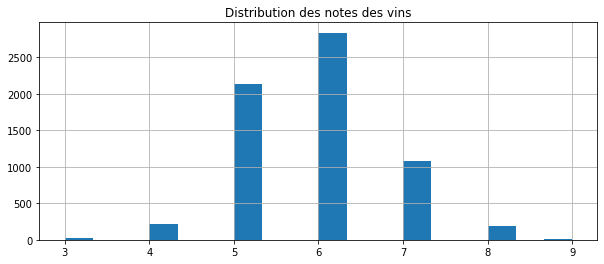

In [ ]:

plt.close('all')
#plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
vins.quality.hist(bins=18, ax=ax)
plt.title('Distribution des notes des vins')
plt.show()

Les vins avec une note de 3 et 9 sont peu représentés avec seulement 5-10 echantillions, ce qui risque de poser un peu de problème de sur apprentissage.

Nous examiner les caractéristiques des variables et surtout les relations entre ces variables. Pour cela on utilise une méthode d”analyse factorielle pour mettre en évidence des relations entre les variables quantitatives (mesures physico-chimique) et la variable quantitative illustrative "quality".

Nous allons lancer une analyse en composante principale (ACP) pour représenter un ensemble de points dans un espace de dimension.
## Analyse en composante principale ACP

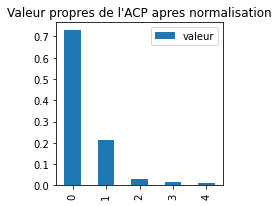

In [ ]:
pca = PCA(n_components=5)
Xn = normalize(X)
pca.fit(Xn)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,svd_solver='auto', tol=0.0, whiten=False)


eig = pd.DataFrame(dict(valeur=pca.explained_variance_ratio_))
ax = eig.plot(kind='bar', figsize=(3,3))
ax.set_title("Valeur propres de l'ACP apres normalisation");
plt.show()

Nous avons les 2 premiers axes qui regroupent plus de 90% des informations.
Regardons les coordonnées du premier v1 et deuxième v2 axe.

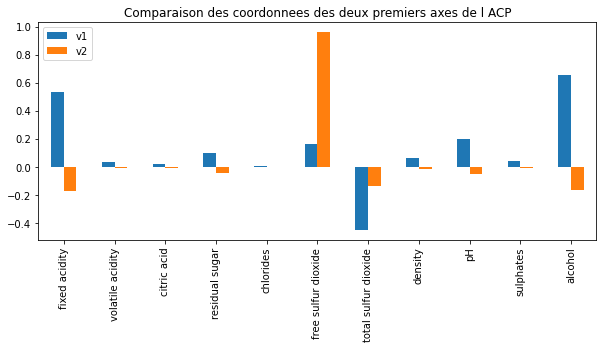

In [ ]:
v2 = pd.DataFrame(pca.components_[0:2,:]).T
v2.index = vins.columns[:-2]
v2.columns = ['v1', 'v2']

ax = v2.plot(y=['v1', 'v2'], kind='bar', figsize=(10,4))
ax.legend(loc='upper left')
ax.set_title("Comparaison des coordonnees des deux premiers axes de l ACP")


plt.show()

On remarque que l’alcool, l’acidité, le dioxyde, le pH semble jouer un rôle plus grand que les autres variables

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


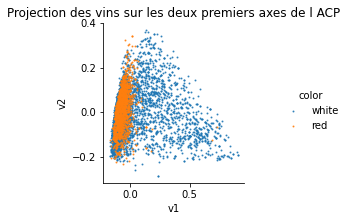

In [ ]:
proj = pca.transform(Xn)

pl = pd.DataFrame(proj[:, :3])
pl.columns = ['v1', 'v2', 'v3']
wine = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Wine/vinsquality.csv', sep=';')
pl['quality'] = wine['quality']
pl['color'] = wine['color']

#Premier graphe selon les couleurs.

ax = sns.lmplot(x="v1", y="v2", hue="color", truncate=True, data=pl, scatter_kws={"s": 1}, fit_reg=False, size=3)
ax.ax.set_title("Projection des vins sur les deux premiers axes de l ACP");

plt.show()

Avec l'ACP on remarque avec le grahe que les vins blancs et rouges pourraient être différents chimiquement et qu'il y a une frontière entre les vins. Il est donc possible de prédire la couleur en fonction des données disponibles dans ce jeu de données via une classification. Cependant ce n'est pas l'objectif de se projet.

On représente maintenant les notes des vins.
##Représentations des notes des vins.

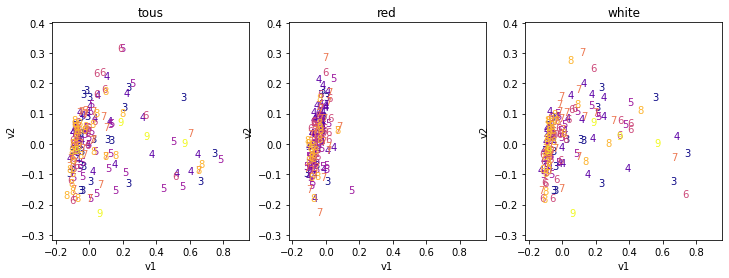

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
red = pl[pl.color == 'red']
white = pl[pl.color == 'white']

# Choisir un dégragé ici
cmap = plt.get_cmap('plasma')
cnorm = colors.Normalize(vmin=pl['quality'].min(), vmax=pl['quality'].max())
scalar = cmx.ScalarMappable(norm=cnorm, cmap=cmap)

for i, data, title in [(0, pl, 'tous'), (1, red, 'red'), (2, white, 'white')]:
    ax = axs[i]
    # On trace les points pour que le texte n'apparaissent pas en dehors des zones
    pl.plot(x='v1', y='v2', kind='scatter', color="white", ax=ax)

    for note in sorted(set(data['quality'])):
        sub = data[data.quality == note]
        if sub.shape[0] > 100:
            sub = sub.sample(n=30)

        color = scalar.to_rgba(note)
        for i, row in enumerate(sub.itertuples()):
            ax.text(row[1], row[2], str(row[4]), color=color)
    ax.set_title(title);
    
    
plt.show()  

Les vins rouges et blancs apparaissent comme très différents, cela vaudra sans doute le coup de faire deux modèles si la performance n’est pas assez bonne. Les bonnes notes ne se détache pas particulièremnt sur ces graphes. Le problème est peut-être simple mais ce ne sont pas ces graphes qui vont nous le dire.

Nous allons voir plus en détails les relations entre les variables avec une analyse plus poussée de l'ACP via la programation sur R en annexe.


Maintenant on va choisir quel algorithme est le plus précis pour prédire la note d'un vin. Nous allons tester 6 algorithmes pour avoir la meilleure prédiction possible.


*1.Random Forests*

*2.Logistic Regression*

*3.Stochastic Gradient Decent Classifier*

*4.Decision Trees*

*5.SVM*

*6.Plus proche voisins knn*




Voici les algorithmes que nous allons tester avec des hyperparametres par défaut.

#3.Les modèles d'algorithmes


## Découpage des jeux de données training et Testing

In [ ]:
#Now seperate the dataset as response variable and feature variabes
X = vins.drop(['quality','color'], axis = 1)
y = vins['quality']

#Train and Test splitting of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#Applying Standard scaling to get optimized result
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Nous allons d'abord diviser les données en deux. 80% de des données iront dans la partie training pour entrainer le modèle et les 20% restants des données iront dans la partie test pour la validation  du modèle.
# Classification

## 1.Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

#Let's see how our model performed
print(classification_report(y_test, pred_rfc))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_rfc), 3))
rfc_defaut=round(metrics.accuracy_score(y_test, pred_rfc), 3)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.80      0.09      0.17        43
           5       0.67      0.72      0.69       402
           6       0.65      0.76      0.70       597
           7       0.72      0.51      0.60       215
           8       0.92      0.33      0.49        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.54      0.35      0.38      1300
weighted avg       0.68      0.67      0.66      1300

Overall Accuracy: 0.669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2.Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
#Let's see how our model performed
print(classification_report(y_test, pred_lr))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_lr), 3))

              precision    recall  f1-score   support

           3       1.00      0.17      0.29         6
           4       0.00      0.00      0.00        43
           5       0.53      0.60      0.56       402
           6       0.54      0.69      0.60       597
           7       0.52      0.20      0.29       215
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1300
   macro avg       0.37      0.24      0.25      1300
weighted avg       0.50      0.53      0.50      1300

Overall Accuracy: 0.534


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

## 3.Stochastic Gradient Decent Classifier

In [ ]:

sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)
print(classification_report(y_test, pred_sgd))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_sgd), 3))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.49      0.72      0.58       402
           6       0.51      0.59      0.55       597
           7       0.25      0.02      0.03       215
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         1

    accuracy                           0.50      1300
   macro avg       0.18      0.19      0.17      1300
weighted avg       0.43      0.50      0.44      1300

Overall Accuracy: 0.496


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred_dt = dt.predict(X_test)
print(classification_report(y_test, pred_dt))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_dt), 3))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.24      0.23      0.24        43
           5       0.56      0.59      0.58       402
           6       0.60      0.56      0.58       597
           7       0.47      0.50      0.49       215
           8       0.25      0.28      0.26        36
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1300
   macro avg       0.30      0.31      0.31      1300
weighted avg       0.54      0.54      0.54      1300

Overall Accuracy: 0.542


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.SVM

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print(classification_report(y_test, pred_svc))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_svc), 3))
svc_defaut=round(metrics.accuracy_score(y_test, pred_svc), 3)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.58      0.65      0.61       402
           6       0.55      0.72      0.62       597
           7       0.61      0.19      0.29       215
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1300
   macro avg       0.25      0.22      0.22      1300
weighted avg       0.53      0.56      0.52      1300

Overall Accuracy: 0.562


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6.Plus proche voisins knn

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)
pred_knn = svc.predict(X_test)

In [ ]:
print(classification_report(y_test, pred_knn))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, pred_knn), 3))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        43
           5       0.58      0.65      0.61       402
           6       0.55      0.72      0.62       597
           7       0.61      0.19      0.29       215
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1300
   macro avg       0.25      0.22      0.22      1300
weighted avg       0.53      0.56      0.52      1300

Overall Accuracy: 0.562


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 7.XGBoost

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


cm = xgb.XGBClassifier(n_estimators = 1000)
cm.fit(X_train, y_train)
y_pred = cm.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred))
print ("Overall Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.15      0.05      0.07        43
           5       0.59      0.61      0.60       402
           6       0.58      0.67      0.62       597
           7       0.51      0.40      0.45       215
           8       0.45      0.14      0.21        36
           9       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.33      0.27      0.28      1300
weighted avg       0.55      0.57      0.55      1300

Overall Accuracy: 0.567


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nous avons trouver que l'algorithme le plus précis est les forets aléatoire avec 0.64% de précision. Puis nous avons les algorithmes arbre de décision, SVM et les plus proche voisins avec 0.56% de precision pour prédire les notes.
Nous allons selectionner et valider les hyperparametres.


#4.Selection/validation des hyperparameters


## Hyperparameters pour les Forets aléatoires

In [ ]:
# Designate distributions to sample hyperparameters from
n_estimators = np.random.uniform(70, 80, 5).astype(int)
max_features = np.random.normal(6, 3, 5).astype(int)

# Check max_features>0 & max_features<=total number of features
max_features[max_features <= 0] = 1
max_features[max_features > X.shape[1]] = X.shape[1]

hyperparameters = {'n_estimators': list(n_estimators),
                   'max_features': list(max_features)}

print (hyperparameters)

{'n_estimators': [70, 78, 79, 72, 75], 'max_features': [2, 2, 1, 4, 5]}


On va sélectionner ces hyperparametres pour l'optimisation de l'algorithme avec RandomizedSearchCV qui est plus rapide en execution que GridSearchCV.

## Randomized search using cross-validation pour les Forets aléatoires

In [ ]:
# Run randomized search
randomCV = RandomizedSearchCV(RandomForestClassifier(), param_distributions=hyperparameters, n_iter=20)
randomCV.fit(X_train, y_train)

# Identify optimal hyperparameter values
best_n_estim      = randomCV.best_params_['n_estimators']
best_max_features = randomCV.best_params_['max_features']

print("The best performing n_estimators value is: {:5d}".format(best_n_estim))
print("The best performing max_features value is: {:5d}".format(best_max_features))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


The best performing n_estimators value is:    70
The best performing max_features value is:     1


On a trouvé les meilleurs hyperparametres donc on va pouvoir lancer l'apprentissage puis on va faire des tests sur les données.
##Apprentissage optimal avec les nouveaux hyperparametres

### L'algorithme RandomForestClassifier

In [ ]:
# Train classifier using optimal hyperparameter values
# We could have also gotten this model out from randomCV.best_estimator_
rfc2 = RandomForestClassifier(n_estimators=best_n_estim,
                            max_features=best_max_features)

rfc2.fit(X_train, y_train)
rfc2_predictions = rfc2.predict(X_test)

print (metrics.classification_report(y_test, rfc2_predictions))

print ("Overall Accuracy optimal:", round(metrics.accuracy_score(y_test, rfc2_predictions), 3))
print("Overall Accuracy par defaut :",rfc_defaut)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.67      0.05      0.09        43
           5       0.67      0.73      0.70       402
           6       0.66      0.77      0.71       597
           7       0.74      0.50      0.60       215
           8       1.00      0.28      0.43        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.53      0.33      0.36      1300
weighted avg       0.68      0.67      0.66      1300

Overall Accuracy optimal: 0.673
Overall Accuracy par defaut : 0.669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On voit qu'il y a eu une amélioration de la précison avec les nouveau hyperparametres. Cependant nous avons encore une trop grande imprécison pour noter les vins surtout à cause des vins noté 9 ou nous avons que 5 echantillions sur les 6400 vins.

In [ ]:

#converting the numpy array to list
xRF=np.array(rfc2_predictions).tolist()

#printing first 5 predictions
print("\nLa prediction pour random Forest:\n")

for i in range(0,5):
  print (xRF[i])
    
    

#printing first five expectations
print("\nLes observations pour random Forest:\n")
print (y_test.head())


La prediction pour random Forest:

6
5
7
5
5

Les observations pour random Forest:

1504    8
1419    5
3162    7
3091    6
2433    6
Name: quality, dtype: int64


On remarque que les notes prédites ne sont pas très fiables.



Maintenant, on va faire un test sur l'algorithme SVM afin de voir si on peut améliorer la précision de la prédiction.
## L'algorithme SVM


In [ ]:
# Designate distributions to sample hyperparameters from
np.random.seed(123)
g_range = np.random.uniform(0.0, 0.3, 5).astype(float)
C_range = np.random.normal(1, 0.1, 5).astype(float)

# Check that gamma>0 and C>0
C_range[C_range < 0] = 0.0001

hyperparameters = {'gamma': list(g_range),
                    'C': list(C_range)}

print (hyperparameters)

{'gamma': [0.2089407556793585, 0.08584180048511383, 0.06805543606926093, 0.16539443072486737, 0.2158406909356689], 'C': [1.0322106068339623, 0.9948482279060615, 0.9795799035361106, 1.197934843277785, 0.8380699934963254]}


## RandomizedSearchCV using cross-validation pour SVM

On prendra l'algorithme SVM avec un noyau non linéaire pour cette prédiction et de type radial basis function car il est très populaire.

In [ ]:
# Run randomized search
randomCV = RandomizedSearchCV(SVC(kernel='rbf', ), param_distributions=hyperparameters, n_iter=20)
randomCV.fit(X_train, y_train)

# Identify optimal hyperparameter values
best_gamma  = randomCV.best_params_['gamma']
best_C      = randomCV.best_params_['C']

print("The best performing gamma value is: {:5.2f}".format(best_gamma))
print("The best performing C value is: {:5.2f}".format(best_C))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


The best performing gamma value is:  0.17
The best performing C value is:  1.20


##Apprentissage optimal avec les nouveaux hyperparametres

*L'algorithme SVM*

In [ ]:
# Train SVM and output predictions
rbfSVM = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
rbfSVM.fit(X_train, y_train)
svm_predictions = rbfSVM.predict(X_test)

print(metrics.classification_report(y_test, svm_predictions))

print("Overall Accuracy optimise:", round(metrics.accuracy_score(y_test, svm_predictions),1))
print(" Overall Accuracy par defaut: ",svc_defaut)


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.50      0.02      0.04        43
           5       0.58      0.66      0.62       402
           6       0.56      0.70      0.62       597
           7       0.58      0.22      0.32       215
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00         1

    accuracy                           0.57      1300
   macro avg       0.32      0.23      0.23      1300
weighted avg       0.55      0.57      0.53      1300

Overall Accuracy optimise: 0.6
 Overall Accuracy par defaut:  0.562


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On remarque que la précision à augmenter mais pas suffisament par rapport à l'algorithme forets aléatoires.

On vérifie avec quelques notes de vins pour l'algorithme SVM

In [ ]:
#converting the numpy array to list
x=np.array(svm_predictions).tolist()

#printing first 5 predictions
print("\nThe prediction SVM:\n")
for i in range(0,5):
    print (x[i])


The prediction SVM:

6
5
7
5
5


In [ ]:
#printing first five expectations
print("\nThe expectation SVM:\n")
print(y_test.head())


The expectation SVM:

1504    8
1419    5
3162    7
3091    6
2433    6
Name: quality, dtype: int64


# Regression

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

print(lm.intercept_)
predictions = lm.predict(X_test)


5.814508370213581


In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.5658453542264533
MSE: 0.5453630356691126
RMSE: 0.7384869908597663


## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=17)
forest.fit(X_train,y_train)



predictions = forest.predict(X_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.4726692307692308
MSE: 0.4032120769230769
RMSE: 0.6349898242673475


In [ ]:
forest_params = {'max_depth': list(range(10, 25)), 
                  'max_features': list(range(6,12))}

locally_best_forest = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=17), 
                                 forest_params, 
                                 scoring='neg_mean_squared_error',  
                                 n_jobs=-1, cv=5,
                                  verbose=True)
locally_best_forest.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24],
                         'max_features': [6, 7, 8, 9, 10, 11]},
             scoring='neg_mean_squared_error', verbose=True)

In [ ]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 22, 'max_features': 6}, -0.3740921939380416)

In [ ]:
predictions = locally_best_forest.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.46688090712390906
MSE: 0.3920974585331478
RMSE: 0.6261768588291552


In [ ]:
data1 = vins.drop(['color'], axis = 1)

In [ ]:
rf_importance = pd.DataFrame(locally_best_forest.best_estimator_.feature_importances_, columns=['coef'], index=data1.columns[:-1]) 
rf_importance.sort_values(by='coef', ascending=False)

,coef
alcohol,0.220228
volatile acidity,0.122412
free sulfur dioxide,0.088146
density,0.087295
sulphates,0.074910
total sulfur dioxide,0.073540
chlorides,0.071706
residual sugar,0.070474
pH,0.069157
citric acid,0.064178


## XGBoost regression

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


regressor=xgb.XGBRegressor(eval_metric='rmse')
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

[22:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.5182693453935476
MSE: 0.4429802770198673
RMSE: 0.665567635195603


Pour 5 exemples, nous avons seulement 2 notes correctes Cependant avec plus d'exemples de vins notés on arrive à 57% pour l'algorithme SVM.

# Conclusion


Le meilleur algorithme pour prédire la note d'un vin pour ce jeu de données est l'algorithme Forets aléatoires. L'optimisation des hyperparametres a permis d'améliorer la precision mais pas de beaucoup.
Ce projet a été très interéssant à réaliser car j'ai appliqué les méthodes vue en cours RCP208 et RCP209 et j'ai aussi utilisé des nouvelles bibliothèques comme Pandas. J'ai aussi utilisé R pour faire les analyse en composante principale qui est plus simple que sur python. Il serait aussi intéressant de faire une classification multi classe pour prédire la couleur du vin.